<h3>Header</h3>

<h5>External Modules</h5>

In [1]:
# Utils
import matplotlib.pyplot as plt
#import pandas as pd
import random
import os
from PIL import Image, ImageOps
import numpy as np

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
#device = 'mps' if torch.backends.mps.is_available()  else 'cpu'
device = 'cpu'
print(f"Using {device} device")

Using cpu device


<h5>Internal Modules</h5>

In [4]:
from dataset import pikfix_dataset, plot_data
from utils.degrade_image import degrade_image
from models.restoration_subnet import RestorationSubNet

<h5>Data path</h5>

In [5]:
# Define dataset root directory and it's csv file
data_dir = './data/'
csv_file = 'dataset.csv'

<h3>Main</h3>

Image degradation

In [6]:
# # Images and textures folder
# images_folder = "data/res"
# textures_folder = "data/textures"

# # Select a random image
# random_img = os.path.join(images_folder, random.choice(os.listdir(images_folder)))

# # Degrade it
# ruined_version = degrade_image(img=random_img, textures_folder=textures_folder, degradation_level=4, scaling_factor=4)

# # Plot the result
# fig, axs = plt.subplots(1, 2, figsize=(12,12))

# plt.subplot(1,2,1)
# plt.imshow(Image.open(random_img), cmap='gray')

# plt.title(f'Original')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(ruined_version, cmap='gray')
# plt.title(f'Ruined')
# plt.axis('off')

# #plt.savefig("version1.jpeg", bboh_inches='tight')

Import dataset

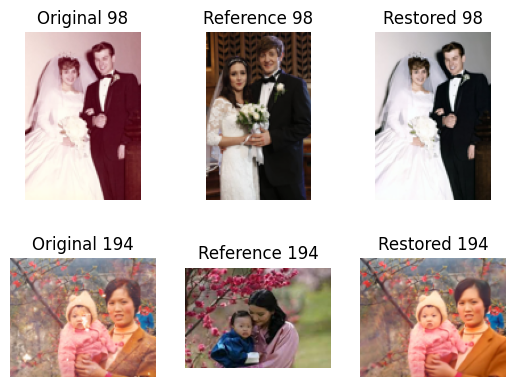

In [7]:
# Define the transformation to be applied on the images in the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Build dataset
dataset = pikfix_dataset.PikFixData(data_dir + csv_file, data_dir, transform, max_size=128)

# Plot some random samples
plot_data.plot_random_samples(2, dataset)

In [8]:
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
it = iter(train_loader)

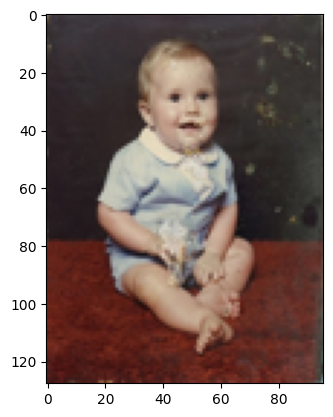

In [9]:
original, reference, restored = next(it)
original = original.to(torch.float32)
plot_data.imshow(original.squeeze())
original = original.to(device)

In [10]:
original.shape

torch.Size([1, 3, 128, 96])

In [11]:
rest = RestorationSubNet(weights="./weights", scale=4)
rest = rest.to(device)

In [12]:
out = rest(original)

In [14]:
out.shape

torch.Size([1, 512, 384])

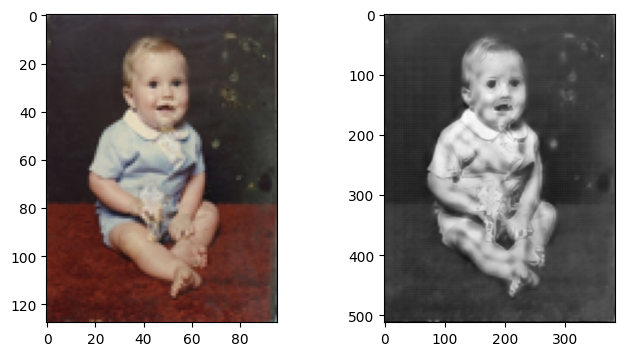

In [15]:
plt.subplots(1,2, figsize=(8,4))

plt.subplot(1,2,1)
original = original.cpu()
plot_data.imshow(original.detach().squeeze())

plt.subplot(1,2,2)
out = out.cpu()
plt.imshow(out.detach().numpy().transpose(1,2,0), cmap='gray')